# FRB Pipeline Simulation

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib.pyplot import *
import gc
from scipy import signal

In [2]:

def axis_labels(x, y, z):
    '''
    Creates the labels for the x, y axes and title as well as triggers the legend
    
    Note: Inputs must be strings
    
    
    INPUTS:
    
    x: (string) The label for the x-axis
    y: (string) The y-axis label
    z: (string) The title for the plot
    
    
    OUTPUTS:
    
    xlab   : The x-axis label
    ylab   : The y-axis label
    titles : The title
    legends: The legend of the plot
    
    '''
    
    xlab = xlabel(x)
    ylab = ylabel(y)
    titles = title(z)
    legends = legend
    return xlab, ylab, titles, legends


def peakfinder_pulsar_DM(x, threshold):
    '''
    Finds the peaks in a dedispersed pulsar that has been run through a matched filter with a Gaussian.
    
    Note: The array or list used for x must have two dimensions. The first specifying which DM we are looking at, and 
          the second representing the number of data points.
          
          The threshold must be appropriate for every DM. This means that it should have the same length as the 
          number of DMs
    
    
    INPUTS:
    
    x         : (array or list) The power of the pulse for every DM that has been looked at.
    threshold : (float) The y value at which peaks can be designated as peaks.
    
    
    OUTPUTS:
    
    peaksy: (list) The values ,for every DM, that can be called peaks over the threshold. 
    
    
    '''
    
    peaksx = [] #This is the values that the peaks are centred around
    peaksy = []
    for j in range(np.shape(x)[0]):
        peakssy= []
        DM_intensity = x[j]
        peak_dex = (list(DM_intensity))
        inversep_dex=DM_intensity[::-1]
        for i in range(len(DM_intensity)-1):
            if DM_intensity[i] > threshold[j] and DM_intensity[i-2]<DM_intensity[i] and DM_intensity[i-1] <DM_intensity[i] and DM_intensity[i+1] < DM_intensity[i] and DM_intensity[i+2] < DM_intensity[i]:
                peakssy.append(DM_intensity[i])
        peaksy.append(peakssy)
    return peaksy

The following steps will simulate the anologue process that occurs before the data is downsampled. Any pulsar will work for this, however, the pulsar being simulated will be made using the paramters below.

In [3]:
#Define the parameters for the noise that will be mixed with the pulse
Cf = 1400e6 #This is the centre frequency in MHz, and where we will be viewing from
Bw = 10e6 #This is the bandwidth that we are observing with our telescope
sample_rate = 12e9 # Frequency running simulation at.
period = .005 #seconds 

With a period of 5ms, we will use a time frame with this length to simulate one pulse. The bins in this simulation is determined by the sampling rate, which can be changed above. The current value is at such that 12GB ram computerss will just be able to simulate. The higher value the sampling rate is given, the more accurate the simulation becomes, but at the expense of what the computer is able to process.

In [4]:
#Define the timescale in which we will be observing
t = np.linspace(-.0025,.0025, period*sample_rate) #Decreasing the period for this will decrease the samples obtained

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


To create the pulsar, first noise is simulated using a normal distribution of values. This distribution is made such that the standard deviation is 1, and is centred around 0. 

In [5]:
#Create the Gaussian noise profile for the pulsar
length = len(t)     #This defines the number of timesamples we have, ie the number of samples collected
mu = 0              #This indicates an offset of 0, meaning the signal is perfetly centred about 0
sigma = 1           #This idicates an std of 1
gnoise = np.random.normal(mu, sigma, length) #This is the GAussian noise for the signal
pw = .0004 #seconds
print(length)

60000000


This noise is then multiplied to a gaussian that has a standard deviation equal to that of the desired pulse width.The gaussian was made using the equation \begin{equation} e^{\frac{-1}{2}(\frac{t}{pw})^2} \end{equation}.

In [6]:
gnoise = np.exp(.5*-(t/pw)**2)*gnoise #Define the pulse of the signal. The gaussian profile takes an input of the 

Observe now that the resulting signal looks like a Gausian distribution

<IPython.core.display.Javascript object>


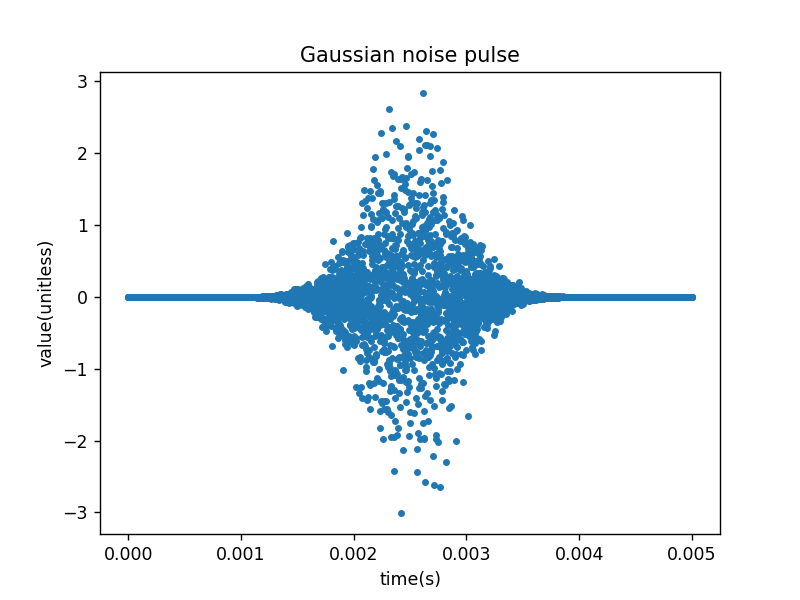

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


(Text(0.5,0,'time(s)'),
 Text(0,0.5,'value(unitless)'),
 Text(0.5,1,'Gaussian noise pulse'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [7]:
#Now plot the signal, and observe the pulse shape. To see the pulse without destroying the computer, 
#plot every 10000th point
figure()
plot(np.linspace(0,.005, period*sample_rate)[0::10000],gnoise[0::10000], ls='none', marker='.')
axis_labels('time(s)', 'value(unitless)', 'Gaussian noise pulse')

Now, to create the pulsar, we take the Fourier transform of the Gaussian, so that we may eliminate all but one frequency of the Gaussian

In [8]:
#Now take the fourier transform of the pulse to get it in frequency space
fourier_pulse = np.fft.fft(gnoise)

The x-axis for the resulting graph is caluclated here. This tells what the frequency step for the broadband noise of the Gaussian is. This is done by taking the fftfreq of the length of the Gaussian, and having it step by the sample rate in units of MHz.

In [9]:
#The fourier transformed data should look like broadband noise, so define the axes properly before plotting
broad_freq = np.fft.fftfreq(length, 1/(sample_rate/1e6)) #This gives the signal in MHz, (specifically from the 1e6)

The plot of the Fourier transform of the Gaussian wave packet is a broadband noise plot as expected.

<IPython.core.display.Javascript object>


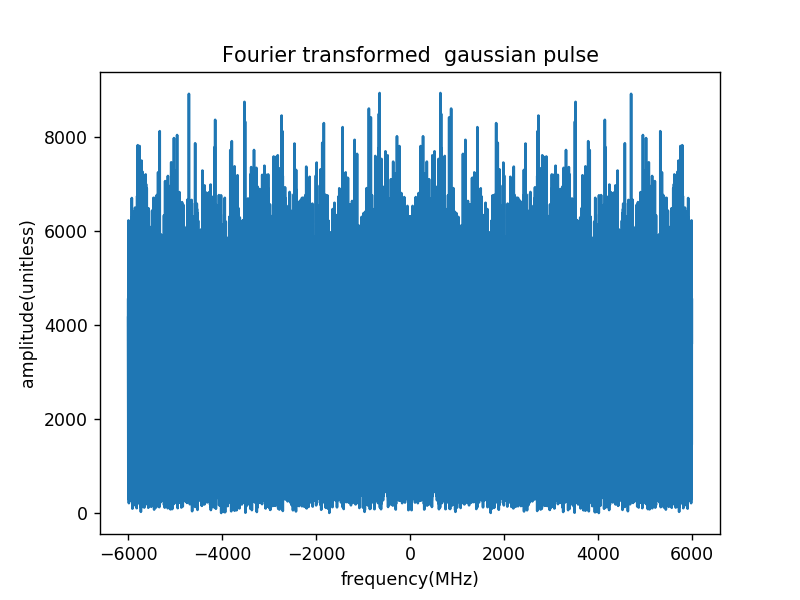

(Text(0.5,0,'frequency(MHz)'),
 Text(0,0.5,'amplitude(unitless)'),
 Text(0.5,1,'Fourier transformed  gaussian pulse'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [10]:
figure()
plot(broad_freq[::1000], np.abs(fourier_pulse[::1000])) #Square the abs value to get better view
axis_labels("frequency(MHz)", 'amplitude(unitless)', 'Fourier transformed  gaussian pulse')

Now, all frequencies outside of our bandwidth are turned to zero. This means that the only values with any values are between 1395 and 1405 MHz. This is true for both the negative frequencies and positive ones between this range.

In [11]:
#Now we modify the noise, so that there are only +- of the same frequency in it of it. This is the pulsar!
#Everything outside the two reference frequencies is turned to zero
highpass_freq = (Cf-Bw/2.0) #This sets the centre frequency to 0, with a bandwidth deifned above
highpass_index1 = int(highpass_freq/(sample_rate/2)*length/2) #This finds the point in the array with the value
highpass_index2 = length - highpass_index1 #Same but for different point
fourier_pulse[:highpass_index1] = 0 #This is turning everything outside the two points to zero
fourier_pulse[highpass_index2:] = 0 #Same as above

#Everything outside of the two frequencies is turned to 0
nyquest_index = int(length/2) #This value is determined by the nyquist sampling theorem(helps figure out where the chinkc are)
#The following is the same as above, but now for outside the frequency values
lowpass_freq = Cf+Bw/2.0 
lowpass_index1 = int(lowpass_freq/(sample_rate/2)*length/2)
lowpass_index2 = length - lowpass_index1
fourier_pulse[lowpass_index1:nyquest_index] = 0
fourier_pulse[nyquest_index:lowpass_index2] = 0

Below is the plot of the new frequencies, As stated before, the only frequencies with nonzero values are those within the bandwidth. This now defines our pulsar, and the frequencies that we will be observing at

<IPython.core.display.Javascript object>


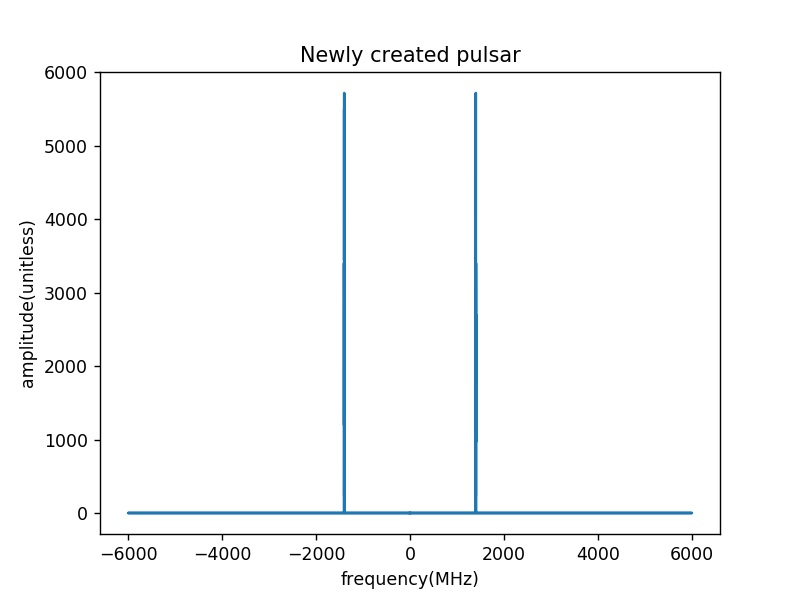

(Text(0.5,0,'frequency(MHz)'),
 Text(0,0.5,'amplitude(unitless)'),
 Text(0.5,1,'Newly created pulsar'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [12]:
figure()
plot(broad_freq[::1000], np.abs(fourier_pulse[::1000]))
axis_labels("frequency(MHz)", 'amplitude(unitless)', 'Newly created pulsar')

This reduced frequency pulsar is now turned back into a timestream and observed to still have a Gaussian shape

In [13]:
#Now turn the pulsar back into time space from frequency space
blimited_pulse = np.fft.ifft(fourier_pulse)

<IPython.core.display.Javascript object>


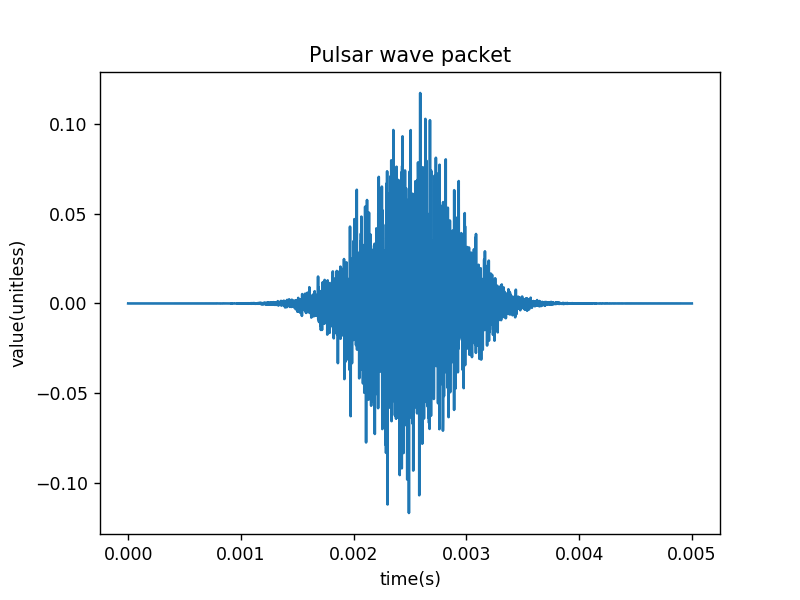

/home/andy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andy/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(Text(0.5,0,'time(s)'),
 Text(0,0.5,'value(unitless)'),
 Text(0.5,1,'Pulsar wave packet'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [14]:
#If this pulse is plotted again, it sill looks like the same as before
figure()
plot(np.linspace(0,.005, period*sample_rate)[0::10000], blimited_pulse[::10000])
axis_labels('time(s)', 'value(unitless)', 'Pulsar wave packet')

To simulate what the computer recieves after the telescope detects the signal, we need to create a mixing signal which will be used to downsample the data. This mixing signal is created using the complex Euler equation:
$e^{-2\pi j *\frac{Cf}{samp}*len}$, where Cf is defined as above, samp is the sample rate, and len is the array with size length, with step size of 1. It is also assumed that the pulse currently is centred around the same point, x=0, which eliminates the \omega that is in the original equation.

In [15]:
#Now need to create the mixing signal:
mixing_signal = np.exp(-2.00j*np.pi* Cf/sample_rate *np.arange(length)) #With this we create the mixing signal using the euler equation for the signal

#We assume the pulse is always centred around the same point, so the only part of the signal equaiton needed is 
#omega*t. 

The pulse is then multiplied to the mixing signal. The fourier transform of this new signal is then taken, and a lowpass filter is applied to it. This is to create an IQ data set for the bandwidth. This filter was made using the nyquist sampling theorem to prevent oversampling with the bandwidth specified. The inverse fourier transform of this signal is then taken, and it is downsampled by taking only samples that have spcings of the $\frac{sample\_ rate}{bandwidth}$

In [16]:

#Mix and sample down the pusar signal so that we can have an I Q data set for the bandwidth
mixedd_down_s = blimited_pulse*mixing_signal
N_cutoff = int(Bw/2/sample_rate*length) #This is from the lowpass fileter definition
fmixed = np.fft.fft(mixedd_down_s) #This creates the fourier transform of the mixed signal
fmixed[N_cutoff:-N_cutoff] = 0.0 # this makes it so that the imaginary magnitudes are comparable to the reals. This is
                                    #also our filter
filtered_mixed_downs_s = np.fft.ifft(fmixed) #This brings the fourier space pulse back into a packet
#Downsample so that is...
downsampled_filtered_mixed_down_s = filtered_mixed_downs_s[::int(sample_rate/(Bw))]
#complex sampled at 10MHz instead of 12GHz
#This gives us 50000 indicies instead of 60000000

To open up more RAM in the computer, variables that will no longer be used are forgotten

In [17]:
#%reset_selective -f 't'
%reset_selective -f gnoise 
%reset_selective -f fourier_pulse
%reset_selective -f broad_freq
%reset_selective -f blimited_pulse
%reset_selective -f mixing_signal
%reset_selective -f mixedd_down_s
%reset_selective -f N_cutoff
%reset_selective -f fmixed
%reset_selective -f filtered_mixed_downs_s


The pulse is now downsampled, and realistically, this is where the simulation can begin. The previous lines of code were used to demonstrate how the anologue to digital converter chain works. Now, the new downsampled signal will be plotted below. Again, this pulsar signal still looks like a wave packet. 

<IPython.core.display.Javascript object>


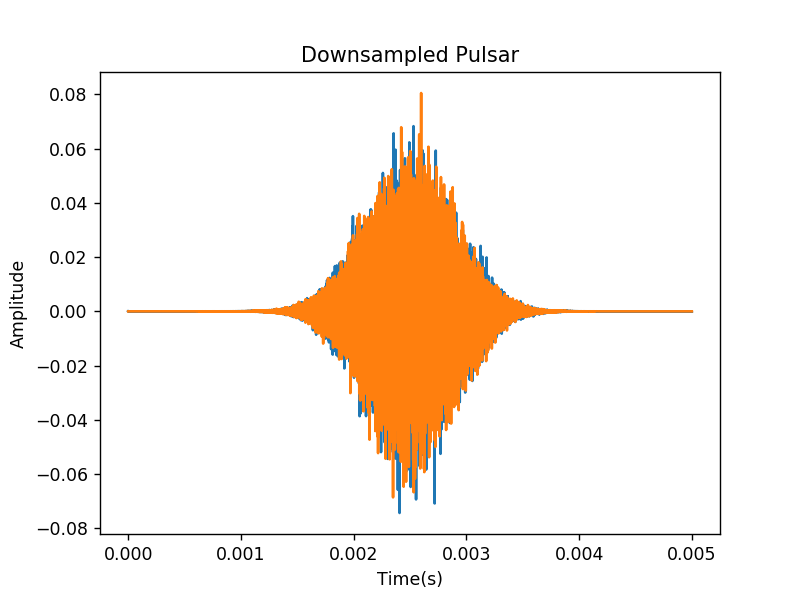

(Text(0.5,0,'Time(s)'),
 Text(0,0.5,'Amplitude'),
 Text(0.5,1,'Downsampled Pulsar'),
 <function matplotlib.pyplot.legend(*args, **kwargs)>)

In [18]:
#The simulation can be run from this point


# Use gaussian noise, filter with same time width.
#Now plot the signal, and observe that the pulse shape is the same, but now using smaller increments between samples
figure()
plot(np.linspace(0,.005, len(downsampled_filtered_mixed_down_s))[0:], downsampled_filtered_mixed_down_s[:].real)
plot(np.linspace(0,.005, len(downsampled_filtered_mixed_down_s))[0:], downsampled_filtered_mixed_down_s[:].imag)
axis_labels('Time(s)', 'Amplitude', 'Downsampled Pulsar')

Right now, there is a single pulse, so this is more of an FRB than a pulsar. In order to make this a repeating pulse, use numpy to repeat it. Below, this was done 30 times to get a nice sample of pulses.

In [19]:
#We repeat the pulse to get about 0.15 seconds of data
repetition = 30 #Gives total number of desired pulses
time_length = .005*repetition
downsampledd_filtered_mixed_down_s_repeated = np.tile(downsampled_filtered_mixed_down_s, 30)


Now finally, the pulsar is dispersed, which is what the telescope would show the pulsar as. The number of time samples of the new repeated pulse is found, and this is used to find the frequency steps for the pulse. A Dispersion measure (DM) is arbitrarilly chosen. Then the fourier transform of the delay time, given by the equation
\begin{equation}4.15e6 *DM*(\frac{1}{\nu_1^2}-\frac{1}{\nu_2^2}) \end{equation} is taken. This equation assumes a frequency given in MHz, however here, it is given in Hz. Therefore, the equation is multiplied by 1e6^2 which, when multiplied to the original 4.15e3 constant, will give the appropriate constant below.

In [20]:
#This is where the pulsar is dispersed
#We do a convolution in fourier space, which must be long wrt the dispersion delay time
dis_length = len(downsampledd_filtered_mixed_down_s_repeated) #This gives us the number of time samples of the 
                                                             #downsampled repeated pulse
freq_step = np.linspace(-Bw/2, Bw/2, dis_length) #This is the new frequency step for the pulse
DM = 20 #This is the dispersion measure and it is completely arbitrary

#Create the signal to be convolved with the data. This signal is what disperses the pulsar
H = np.exp(2j*np.pi*4.15e15*DM*freq_step**2/((Cf+freq_step)*Cf**2)) #Where the part that looks similar to the delay 
#time is the 'time' portion of the equation

As a precaution, the delay time is checked to ensure that it is less than the dispersion time of the data

In [21]:
#Check how long the dispersion is
delay_time = 4.15e15 * (1/(Cf-Bw/2)**2 - 1/(Cf+Bw/2)**2) * DM

#The delay time must be significantly less than the dispersion of the data
print(delay_time) #This time must be less thah H

0.0006049717010747074


The pulse signal and the dispersion function are convolved together, and the outcome is the dispersed pulse train. However when taking the fft and ifft, a overall gain is added to the signal, unless the norm of the fft and ifft is set to 'ortho' which will ensure no gain is applied to the signal. 

In [22]:
dispersed_downsampled_filtered_mixed_sig = np.fft.ifft(np.fft.fft(downsampledd_filtered_mixed_down_s_repeated, norm='ortho')*np.fft.fftshift(H), norm='ortho')
#The pulse signal and the dispersion of the pulse were convolved to give a dispersed pulse

The pulse has successfully been dispersed

<IPython.core.display.Javascript object>


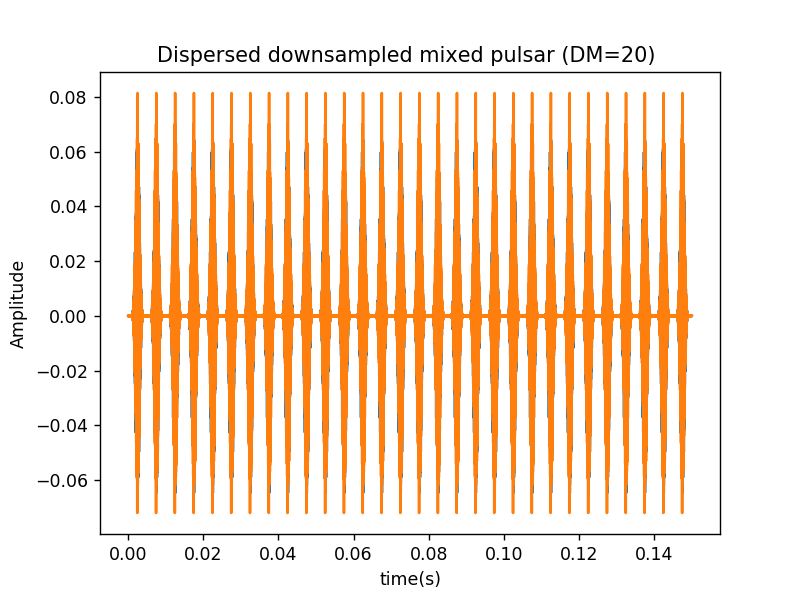

In [23]:
#Plotting the convolved signal...
figure()
plot(np.linspace(0,.15, dis_length)[:], dispersed_downsampled_filtered_mixed_sig[:].real)
plot(np.linspace(0,.15, dis_length)[:], dispersed_downsampled_filtered_mixed_sig[:].imag)
axis_labels('time(s)', 'Amplitude', 'Dispersed downsampled mixed pulsar (DM=20) ')
savefig('/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/despirsed_pulse_DM=20.png')

To simulate a real pulse, noise is added to the pulse train. This is white noise generated by choosing a random selection of values within a amplitude range of the pulse,and adding imaginary and real noise to the pulses. The noise_and_signal is the original signal with 1500000 points with en equal number of points appended to the beginning of the array

In [24]:
#Noise is added to the pulse to simulate the RFI environment
noise_interval = 1 #This tells us how many samples from the noise to concatinate
noise_varience = .05

noise1 = np.random.normal(0,noise_varience,len(dispersed_downsampled_filtered_mixed_sig),)
noise2 =  np.random.normal(0,noise_varience,len(dispersed_downsampled_filtered_mixed_sig),)*1j
dispersed_downsampled_filtered_mixed_sig = dispersed_downsampled_filtered_mixed_sig+noise1+noise2
all_noise = noise1+noise2

noise_and_signal = np.concatenate([all_noise[::noise_interval],dispersed_downsampled_filtered_mixed_sig])#The noise and signal have been concatenated as if 
                                              #They were observed right after another 
shapes = all_noise[::noise_interval].shape[0] #Tells us where the end of just noise is and where the signal begins
pure_signal = noise_and_signal[shapes:] #This gives the signal with noise
pure_noise = noise_and_signal[:shapes]  #This gives pure noise

The new pulse with noise is shown below

<IPython.core.display.Javascript object>


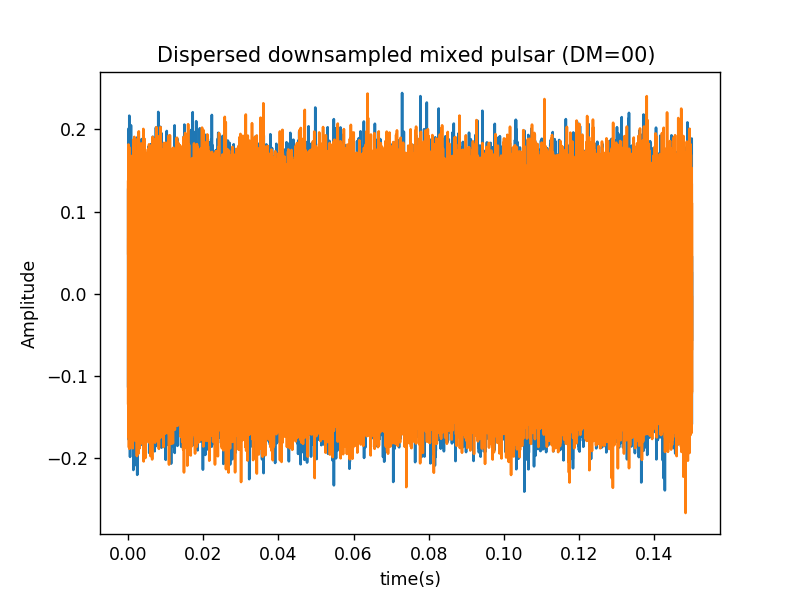

In [25]:
figure()
plot(np.linspace(0,.15, dis_length),pure_noise.real)
plot(np.linspace(0,.15, dis_length),pure_noise.imag)
axis_labels('time(s)', 'Amplitude', 'Dispersed downsampled mixed pulsar (DM=00) ')
savefig('/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/despirsed_pulse_with_noise_DM=20.png')

From this point, the pulse can be saved to a file and used as a simulated pulse inside GNUradio. The signal is divided by the maximum value of the real and imaginary parts and multiplied by the length of an int16 unit. This is then passed to the rest of the pipeline. For saving the file, an array with twice the length of the data is created and the real values are saved as the even indicies while the imaginary values are saved as the odd indicies.

In [26]:
pure_signal.dtype
rmax = pure_signal.real.max()
print(rmax)
immax = pure_signal.imag.max()
print(immax)
int_max = 2**15-2
print(int_max)
dmax = max(rmax,immax)
print(dmax)
dispersed_downsampled_filtered_mixed_signal = pure_signal*int_max/dmax
dispersed_downsampled_filtered_mixed_down_s_real = dispersed_downsampled_filtered_mixed_signal.real.astype(np.int16)
dispersed_downsampled_filtered_mixed_down_s_imag = dispersed_downsampled_filtered_mixed_signal.imag.astype(np.int16)
out = np.zeros(2*len(dispersed_downsampled_filtered_mixed_down_s_real), dtype=np.int16)
out[::2] = dispersed_downsampled_filtered_mixed_down_s_real
out[1::2] = dispersed_downsampled_filtered_mixed_down_s_imag
out.tofile('/home/andy/FRB_Pipeline_and_Contributions/gr-transient/jupyter/pulse_sim_10mhz_int16_5ms_period_60dm_1400MHz_center_150ms_long.bin')

0.2514491225068193
0.2443886304941589
32766
0.2514491225068193


Now this is how this is how the pulse looks when it enters into the computer. The task is to now dedisperse it. We want an integration time that is dependent on the bandwidth. Therefore the inverse of the bandwidth is taken as the time that comes from the bandwidth. 

In [27]:
#We want a 10Msps, since this is the bandwidth
times = 1/10e6
#Make the pure noise have the same apmlitude as the signal
pure_noise = pure_noise*int_max/dmax

The number of desired frequency channels is set. This is an arbitrary choice. The integration size determins the signal to noise ratio of the data. An integration number of .2ms is chosen, since it is much smaller than the pulse width. Therefore, the resulting number of integrations done on the pulsar is 5. Finally, the number of timesteps for the pulse is calculated by the ratio of samples in the signal to the product of the number of frequency channels and integration size. This will dictate how many timesteps will be seen in the data.

With these parameters, the FFT of the data per timestep is done, and arranged into an array as frequency by time.


The same process is done with the noise, but using the length of the noise instead of the data for finding the number of timesteps. 

In [28]:

#To check that this number of frequencies, integrations, and sampling rate work
#integrate 5 samples
integration_time = 2e-4 #seconds, this is the 1/.2ms integration
step = 400 #This comes from the number of frequency channels desired. This is an educated, but arbitrary choice
integration_size = int(integration_time/(times)/step) #This comes from the 0.2ms integration that we desire. It is .2 bc .1 was too small
n_time = int(len(dispersed_downsampled_filtered_mixed_signal)/step/integration_size) #This finds the number of
                                                            #timesteps
rec_spect = np.zeros(((n_time), step), dtype=complex) #This the is the recieved 3d plot of frequency vs time
for i in range(n_time): #This is the number of 'rows'
    for j in range(integration_size):
        spect = np.fft.fft(dispersed_downsampled_filtered_mixed_signal[(integration_size*i+j)*step : (integration_size*i+j+1)*step])
        #This is an easy way to get the row size that we desire
        rec_spect[i] += spect*spect.conjugate() #The first timestep of the frequencies needs to be multiplied by its conjugate
        #The spetra are added together because we are 'folding' the amplitudes together. If we don't, then there appears 
        #a jump in the data.

#Define the constants for the noise data set
n_noise_time = int(len(pure_noise)/step/integration_size) #Number of timesteps for the noise
        
bb_noise = np.zeros((n_noise_time,step), dtype = complex) #This is the 3d array of the noise        
for i in range(n_noise_time): #This is the number of 'rows'
    for j in range(integration_size):
        spect_n = np.fft.fft(pure_noise[(integration_size*i+j)*step : (integration_size*i+j+1)*step])
        #This is an easy way to get the row size that we desire
        bb_noise[i] += spect_n*spect_n.conjugate() #The first timestep of the frequencies needs to be multiplied by its conjugate
        #The spetra are added together because we are 'folding' the amplitudes together. If we don't, then there appears 
        #a jump in the data.    

The estimated signal to noise of the pulse can now be calculated. This will be compared to the SNR that will be obtained at the end. The amplitude however has to be estimated by hand, since it will always change.

In [29]:
estimated_noise = 1/(noise_varience/.069)**2*5
print(estimated_noise)

9.521999999999998


For bench testing purposes, the pulse that has now gone through an FFT and been integrated will be compared to the integration and FFT blocks in GNUradio. 

In [30]:
rmax_FFT = rec_spect.real.max()
print(rmax)
immax_FFT = rec_spect.imag.max()
print(immax)
int_max = 2**15-2
print(int_max)
dmax_FFT = max(rmax_FFT,immax_FFT)
recieved_spect = (np.fft.fftshift(rec_spect))
rec_spect_real = recieved_spect.real.astype(np.float32)
out_spec = np.zeros((len(rec_spect_real),step), dtype=np.float32)
for i in range(step):
    out_spec[:1071,i] = rec_spect_real[:,i]
out_spec.tofile('/home/andy/FRB_Pipeline_and_Contributions/gr-transient/jupyter/pulse_sim_10mhz_int16_5ms_period_60dm_1400MHz_center_150ms_long_integrated_FFT.bin')

0.2514491225068193
0.2443886304941589
32766


In [31]:
1/(noise_varience/.066)**2*integration_size

8.712000000000002

In order to get this into a more conventional array, the transpose of the FFTed and integrated data is taken, so that it is arranged frequency by time. Then the y axis of the plot is created, where first the number of frequency channels is found, then the centre frequency of that array is set at 1400MHz

In [32]:
n_frequencies = np.fft.fftfreq(step, 1/(10e6/1e6)) #This is the number of frequency channles.The first parameter 
                                #should be the number of chanels desired, and the second is the sample rate in MHz.
                                #This will lable the the x axis
pulse_freqs = np.fft.fftshift(n_frequencies)+Cf/1e6 #This will place the centre frequency of the plot at 1400MHz
dispersed = np.flip(np.transpose(np.fft.fftshift((rec_spect))), 0)#The array of the data must be flipped to match 
                                    #the units in the plot,and it must be transposed so that time is on the x axis.
bb_flipped = np.flip(np.transpose(np.fft.fftshift(bb_noise)),0)

The 3d graph of the dispersed pulsar is then plotted

<IPython.core.display.Javascript object>


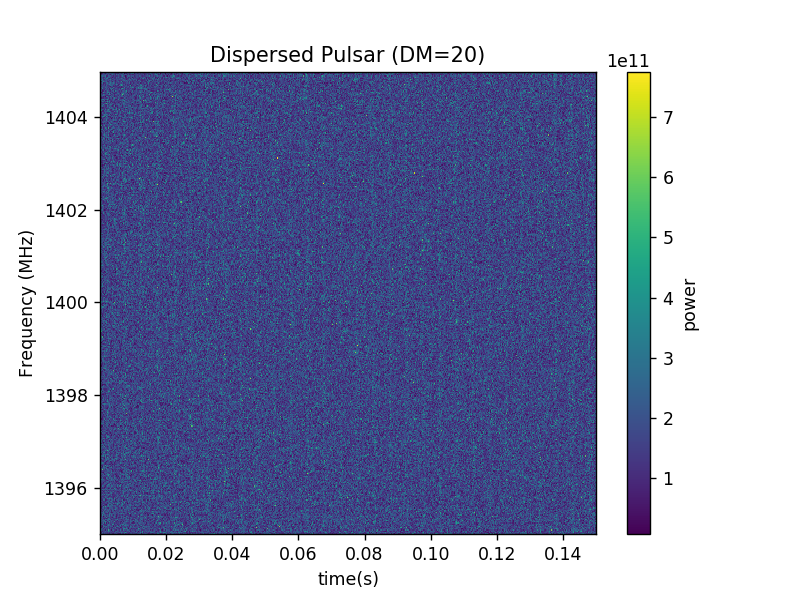

In [33]:
#This is the graph of the pulsar, where we can see that it is dispersed
figure()
imshow(abs(dispersed), extent=[np.amin(np.linspace(0,.15, dis_length)),\
                            np.amax(np.linspace(0,.15, dis_length)),\
                            np.amin(pulse_freqs),\
                            np.amax(pulse_freqs)],\
                              aspect='auto')
axis_labels('time(s)','Frequency (MHz)',  'Dispersed Pulsar (DM=20)')
colorbar(label = 'power')
savefig("/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/Dispersed_pulsar_DM=20_noisy.png")
#Congrats!, we now have a dispersed pulsar


This the the 3d plot of the noise behind the plot

<IPython.core.display.Javascript object>


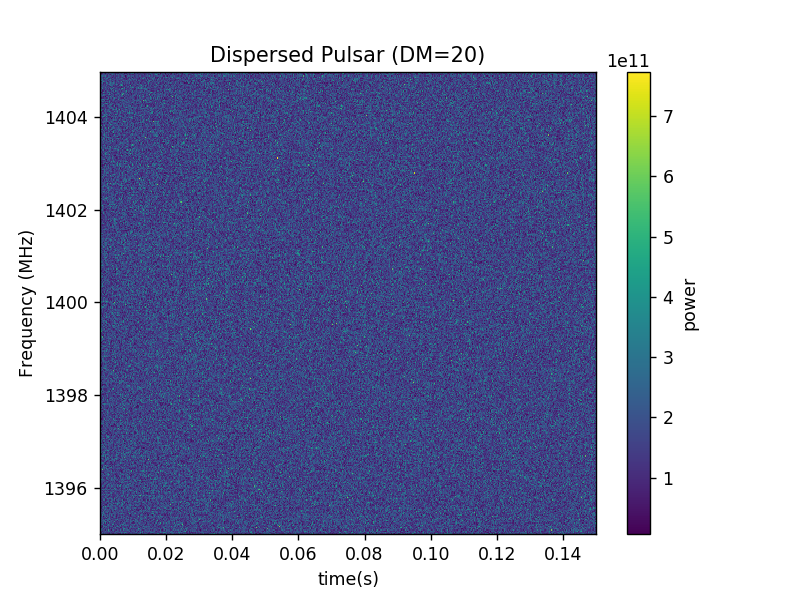

In [34]:
figure()
imshow(abs(bb_flipped), extent=[np.amin(np.linspace(0,.15, dis_length)),\
                            np.amax(np.linspace(0,.15, dis_length)),\
                            np.amin(pulse_freqs),\
                            np.amax(pulse_freqs)],\
                              aspect='auto')
axis_labels('time(s)','Frequency (MHz)',  'Dispersed Pulsar (DM=20)')
colorbar(label = 'power')
savefig("/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/Noise_DM=20_noisy.png")


Now the pulsar is attempted to be dedispersed. Assume that the DM, nor the period of the pulsar is known. An array of possible DM's is created, along with a timestep array of when the pulses arrive. Then using the time delay equation used to disperse the pulsar, the time changes for every frequency are calculated. This is repeated for each trial dispersion measure.

In [35]:
DMs = np.linspace(0,200,201) #Assume that we do not know the DM for the pulsar. We must then Guess a range of DM

time_change = np.zeros((len(DMs), step)) #This is the time after the first frequency which the second frequncy arrives
for i in range(len(DMs)):
    change = 4.148e3*DMs[i]*( 1/(np.min(pulse_freqs))**2 - 1/( pulse_freqs )**2) #This is the definition for the time that the second freq arrives
    time_change[i,:] = change[:]


Using the time delays, the pulsar is now dedispersed for every guessed DM. This is done by using numpy.roll. The threshold for the roll is set by finding the time that each element in the data corresponds to, and moving elements so that they line up with their corresponding elements(come back to give better explanation)

In [36]:
def dedispersion(DMss, frequency_channels, dispersed_pulse, time_change, n_time, integration_size): 
    """The function takes a set of DMs and dedisperses the given dispersed pulse for all the DMs given."""
    dedispers = np.zeros((len(DMss),dispersed_pulse.shape[0], dispersed_pulse.shape[1]))  #The dedispersed pulse will have the same shape as the dispersed one
    for i in range(len(DMss)):
        dedis = dispersed_pulse*0
        for j in range(frequency_channels):
            dedis[j,:] = np.roll(dispersed_pulse[j,:],-int(round(time_change[i,j]/(time_length/n_time))) )#np.roll shifts 
                #the data over after the last position and reintroduces it to the first position
        dedispers[i,:,:] = dedis
    return dedispers

Using the above definition, the pulse is dedispersed

In [37]:
dedisperse = dedispersion(DMs, step, abs(dispersed), time_change, n_time, integration_size)  #The dedispersed pulse will have the same shape as the dispersed one
dedisperse_bb = dedispersion(DMs,step,abs(bb_flipped), time_change, n_time, integration_size)

One DM value for the pulse is then plotted below

<IPython.core.display.Javascript object>


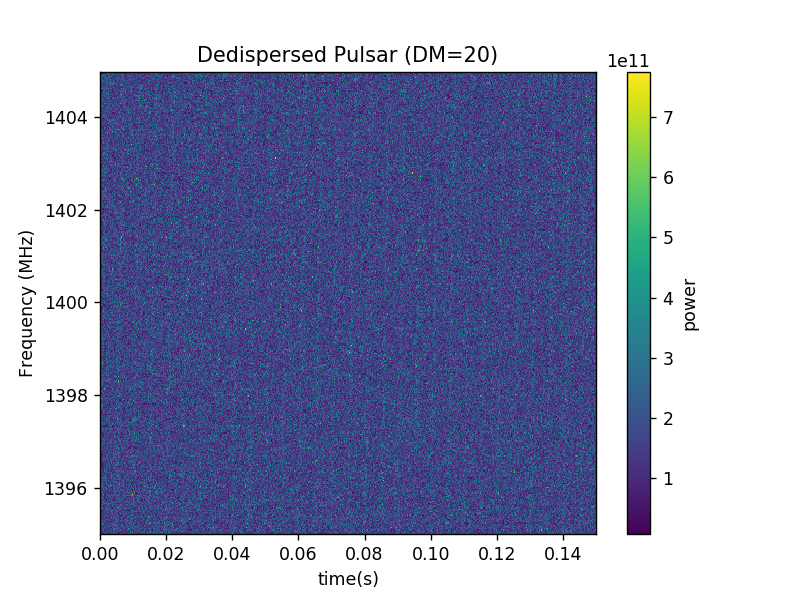

In [38]:
figure()
imshow(abs(dedisperse[100]), extent=[np.amin(np.linspace(0,.15, dis_length)),\
                            np.amax(np.linspace(0,.15, dis_length)),\
                            np.amin(pulse_freqs),\
                            np.amax(pulse_freqs)],\
                              aspect='auto')
axis_labels('time(s)','Frequency (MHz)',  'Dedispersed Pulsar (DM=20)')
colorbar(label = 'power') #This shows the effec the dedispersion had on the 200th DM
savefig("/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/Dedispersed_pulsar_DM=20_noisy.png")

To create a DM vs time plot, the array is summed along the frequency axis for every DM

In [39]:
DM_measure = np.sum(dedisperse, axis = 1)
bb_measure = np.sum(dedisperse_bb, axis = 1)

This new array is then plotted below. Note that the graph appears to have a wave in the region with the highest amplitudes. This is caused by the moire effect which can be shown as the cause with the graph following the one below(see pic for no noise pulsar)

<IPython.core.display.Javascript object>


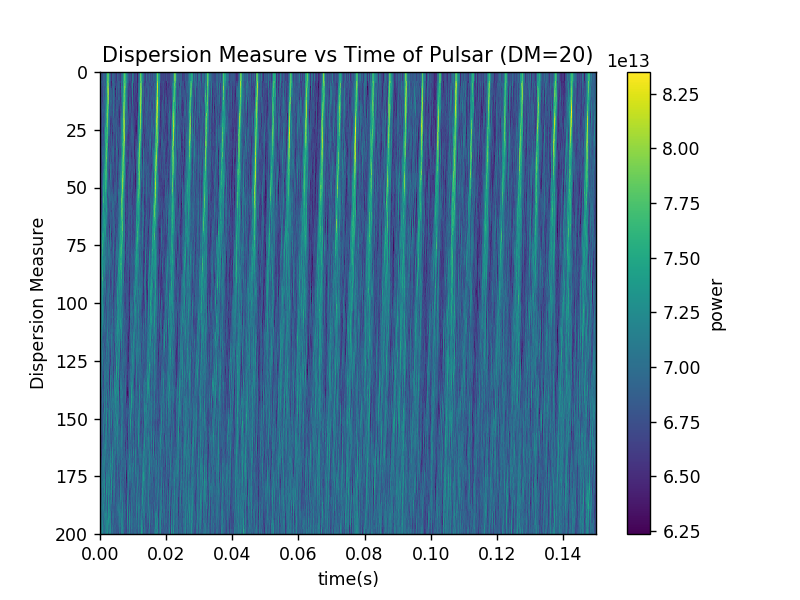

In [40]:
figure()
imshow((abs(DM_measure)), extent=[np.amin(np.linspace(0,.15, dis_length)),\
                            np.amax(np.linspace(0,.15, dis_length)),\
                            np.amax(DMs),np.amin(DMs)
                            ],\
                              aspect='auto')
axis_labels('time(s)','Dispersion Measure',  'Dispersion Measure vs Time of Pulsar (DM=20)')
colorbar(label = 'power') #This is the plot of DM vs time
savefig("/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/dispersion_measure_vs_time_DM=20_noisy.png")

To detect whether or not a pulsar or FRB was detected, a matched filter will be implemented. Since we are dealing with an ideal case of white noise, then the filter that will be applied will be a pulse of the same width as the signal. This width is calculated by taking the original sigma of simulated pulse and dividing it by the final timestep after all modification of the pulse is done. This occurrs after integration. Then the gaussian pulse that will be used as the filter is created. The length is made such that packets are not significantly overlapping.

In [41]:
#Now we will begin to try to impliment the matched filter
#Define the standard deviation of the noise

#Define the pulse shape by the standard deviation of one pulse
packet_length = int(len(downsampled_filtered_mixed_down_s)/step/(integration_size))
standards = pw/(period/packet_length)

gau = np.exp(.5*-( np.arange(-int(packet_length/2),int(packet_length/2)) /standards)**2)

The cross correlation between the data and the filter is the implemented below. The correlation for signal and filter is specified to give the same shaped array as the data given to it. The noise is also run through the matched filter, but the correlation is specified to give onyl real values. This ensures that the standard deviation will not be increased by a factor of ten from if just the real valued correlations were taken. 

In [42]:
#Now perform the cross correlation between the signal and the simulated
correlates = []
corr_bb = []
for i in range(len(DM_measure)):
    correlates.append(signal.correlate(DM_measure[i], gau, mode='same'))
    corr_bb.append(signal.correlate(bb_measure[i],gau,mode='valid'))
correlates = np.asarray(correlates)
corr_bb = np.asarray(corr_bb)


The pulsar will be considered detected if the signal to noise ratio, given by
\begin{equation} \frac{\langle y \rangle}{\sigma_y} \end{equation}
is over a threshold. The average value of y is the average value of the correlated signal. This is found by using a peak finding function for each DM and then take the average of those peaks.

In [43]:
#We can find the peaks
mean_heights = np.zeros(len(correlates))
for i in range(len(correlates)):
    mean_heights[i] = np.mean(correlates[i])
peak_heights = peakfinder_pulsar_DM(correlates, mean_heights)

Now the vaience of the non pulse signal is found. This is done by pointing the telescope somewhere else and observing the noise for a brief period. The data collected is assumed to not have a pulsar in it. This data, which by this point has been run through the matched filter, is used to now find the mean and standard deviation along the time axis.

In [44]:
maximums = np.zeros(len(peak_heights))
for i in range(len(peak_heights)):
    maximums[i] = np.mean(peak_heights[i])
    
#Find the mean and standard deviation
corr_mean = np.mean(corr_bb, axis=1)
corr_std = np.std(corr_bb, axis=1)

SNR = (maximums-corr_mean)/(corr_std)

The plot of SNR to DM is plotted

<IPython.core.display.Javascript object>


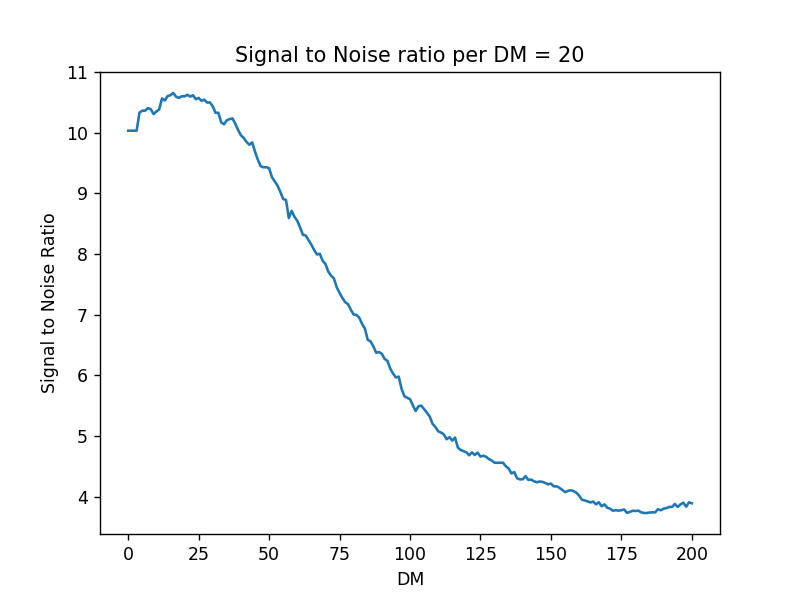

In [45]:
figure()
plot(DMs,SNR)
axis_labels('DM', 'Signal to Noise Ratio', 'Signal to Noise ratio per DM = 20')
savefig("/home/andy/FRB_Pipeline_and_Contributions/gr-transient/documentation/SNR_vs_DM_DM=20_noisy.png")

Finally we will check if a pulsar or FRB has been found

In [47]:
#Checking for a pulsar:
if len(np.where(SNR>10)[0]) >5:
    Pulsar = True
else:
    Pulsar = False

print(Pulsar)


True
